In [1]:
import pandas as pd
import numpy as np
import ChartingFunctions.plot_strategy as plt_st
import matplotlib.pyplot as plt
import Labeling.getDailyVol as gdv
import Sampling.Sampling as spl
import Labeling.TBM as tbm
import Labeling.getLabel as gl
import Trading.strategy as strategy
import FractDiff.fractdiff as fdiff

In [2]:
class Indicator:

    def __init__(self, open, high, low, close):
        self.open = open
        self.high = high
        self.low = low
        self.close = close
    
    # Money flow multiplier
    def mfm(self):
        return ((self.close - self.low)- (self.high - self.close))/(self.high - self.low)


In [53]:
df = pd.read_parquet("IntradayData/BTCUSD_2020-04-07_2022-04-06.parquet")
df = df.set_index('DATE')
close = df['CLOSE']

In [115]:
label = Labelling(close)
l1 = label.min_max(20, len(close))

In [116]:
df_['side'] = l1

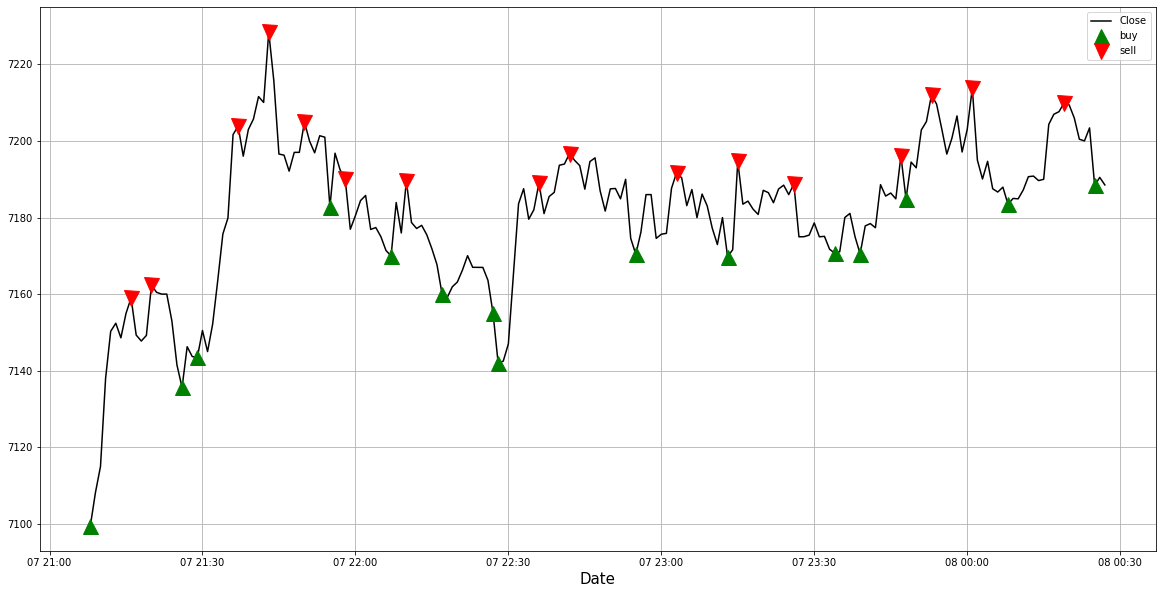

In [117]:
plt_st.plot_position(df_,200,400)

In [114]:
class Labelling:

    def __init__(self, value):
        self.value = value

    # Min max
    def min_max(self, window, total):
        
        label = pd.Series(index=self.value.index,dtype='int8').fillna(0)

        win_start = 0
        win_end = win_start + window
        count_row = 0

        while count_row <= total:
        
            min_value = min(self.value[win_start:win_end])
            max_value = max(self.value[win_start:win_end])
            idx_min = self.value[win_start:win_end].idxmin()
            idx_max = self.value[win_start:win_end].idxmax()
            
            label.loc[idx_min] = 1
            label.loc[idx_max] = -1

            win_start = int((win_end + win_start)/2)
            win_end = win_start + window
            count_row = win_end

        return label

In [5]:
index = Indicator(df['OPEN'],df['HIGHT'],df['LOW'],df['CLOSE'])

In [6]:
index.mfm()

DATE
2020-04-07 17:48:00   -0.095825
2020-04-07 17:49:00    0.315393
2020-04-07 17:50:00    0.305361
2020-04-07 17:51:00   -0.429549
2020-04-07 17:52:00    0.730403
                         ...   
2022-04-06 23:54:00   -0.356082
2022-04-06 23:55:00   -0.180951
2022-04-06 23:56:00   -1.000000
2022-04-06 23:57:00    0.265619
2022-04-06 23:58:00   -0.510865
Length: 1048690, dtype: float64

In [190]:
daily_std = gdv.getDailyVol(close)
trgt = daily_std.dropna()
label = gl.getLabel(close,1,trgt,0.01,0.05,[1,1])

In [191]:
df_close = df[['CLOSE']].merge(label.fillna(0),how='left',left_index=True,right_index=True)
df_close['side'] = 0
df_close.loc[df_close['return']<0,'side'] = -1
df_close.loc[df_close['return']>0,'side'] = 1

In [197]:
df_close[df_close['side']==1].side.sum()

208257

In [215]:
df_close_ = df_close_[['DAY','CLOSE','return','side']].groupby(['DAY']).last()

In [202]:
side_mov_avg,s1,s2 = strategy.cross_moving_average(df_close['CLOSE'],50,20)


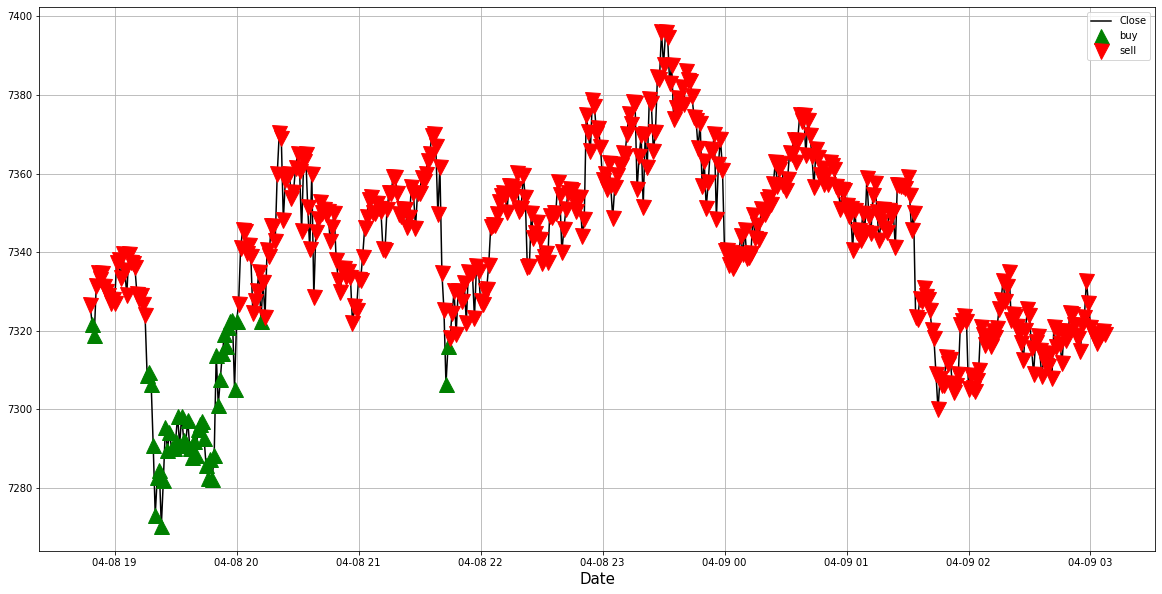

In [220]:
plt_st.plot_position(df_close,1500,2000)

In [ ]:


def plot_position(df,start,end,s1=None, s2=None):
    
    df = df[start:end]

    plt.figure(figsize = (20,10))
    plt.plot(df['CLOSE'],color='k',label='Close')

    # long position
    plt.plot(df[df['side'] == 1].index,df['CLOSE'][df['side'] == 1],
                '^', markersize = 15, color='g', label='buy')

    # short position
    plt.plot(df[df['side'] == -1].index,df['CLOSE'][df['side'] == -1],
                'v', markersize = 15, color='r', label='sell')
    
    if s1 is not None and s2 is not None:

        s1 = s1[start:end]
        s2 = s2[start:end]

        plt.plot(s1,color='b')
        plt.plot(s2,color='y')

                
    plt.xlabel('Date', fontsize = 15 )
    plt.legend()
    plt.grid()
    plt.show()
